# Jupyter Notebook for Task 4: Modeling

#### Preparation

In [29]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

aggregated_data = pd.read_pickle(os.path.join('Data', 'aggregated_data.pkl'))
aggregated_data.head()

,activeSessions_site1,utilizationRate_site1,kWhDelivered_site1,idleRate_site1,blockedRate_site1,activeSessions_site2,utilizationRate_site2,kWhDelivered_site2,idleRate_site2,blockedRate_site2,...,cloud_cover_description,pressure,windspeed,precipitation,hour_of_day,week_of_year,day_of_week,month_of_year,is_weekend,date
start_hour,,,,,,,,,,,,,,,,,,,,,
2018-04-25 04:00:00-07:00,0,0.0,0.0,0.0,0.0,1,0.016029,3.118359,1.000000,0.000000,...,Partly Cloudy,987.47,7.0,0.0,4,17,2,4,False,2018-04-25
2018-04-25 05:00:00-07:00,0,0.0,0.0,0.0,0.0,1,0.018519,3.602725,1.000000,0.000000,...,Partly Cloudy,987.80,15.0,0.0,5,17,2,4,False,2018-04-25
2018-04-25 06:00:00-07:00,0,0.0,0.0,0.0,0.0,3,0.015175,3.170394,1.000000,0.000000,...,Fair,988.45,9.0,0.0,6,17,2,4,False,2018-04-25
2018-04-25 07:00:00-07:00,0,0.0,0.0,0.0,0.0,7,0.059378,12.224048,0.957030,0.002551,...,Fair,988.78,13.0,0.0,7,17,2,4,False,2018-04-25
2018-04-25 08:00:00-07:00,0,0.0,0.0,0.0,0.0,22,0.253596,36.984350,0.926976,0.018519,...,Fair,988.78,13.0,0.0,8,17,2,4,False,2018-04-25


## 1 Cross Validation

Before developing different models for predicting hourly utilization of the sites, we will divide the `aggregated_data` from Task 2 into training and holdout sets. This partitioning is essential for obtaining an unbiased estimate of model performance on unseen data.

In [30]:
from sklearn.model_selection import train_test_split

# Cross Validation for utilizationRate_site1
train_X_ur1, test_X_ur1, train_y_ur1, test_y_ur1 = train_test_split(
    aggregated_data[['hour_of_day', 'week_of_year', 'day_of_week',
       'month_of_year', 'is_weekend', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation']],
    aggregated_data[['utilizationRate_site1']], test_size=0.3)

# Cross Validation for utilizationRate_site2
train_X_ur2, test_X_ur2, train_y_ur2, test_y_ur2 = train_test_split(
    aggregated_data[['hour_of_day', 'week_of_year', 'day_of_week',
       'month_of_year', 'is_weekend', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation']],
    aggregated_data[['utilizationRate_site2']], test_size=0.3)

# Cross Validation for kWhDelivered_total
train_X_kWh, test_X_kWh, train_y_kWh, test_y_kWh = train_test_split(
    aggregated_data[['hour_of_day', 'week_of_year', 'day_of_week',
       'month_of_year', 'is_weekend', 'temperature', 'cloud_cover', 'pressure', 'windspeed', 'precipitation']],
    aggregated_data[['kWhDelivered_total']], test_size=0.3)

***

## 2 SARIMA-Model

In [31]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(window=168).mean()
    rolstd = timeseries.rolling(window=168).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:\n')
    dftest = adfuller(timeseries, maxlag=168)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = "{:,.4f}".format(value)  # Change the format specifier here
    print(dfoutput)

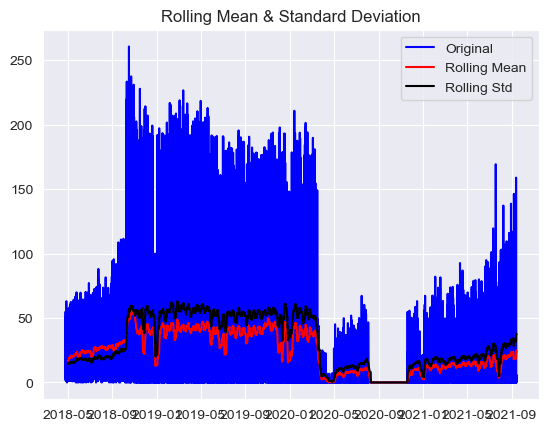

Results of Dickey-Fuller Test:

Test Statistic                -2.575546
p-value                        0.098158
#Lags Used                        168.0
Number of Observations Used     29548.0
Critical Value (1%)             -3.4306
Critical Value (5%)             -2.8616
Critical Value (10%)            -2.5668
dtype: object


In [32]:
df = aggregated_data.copy()
test_stationarity(df['kWhDelivered_total'])

23401
23400


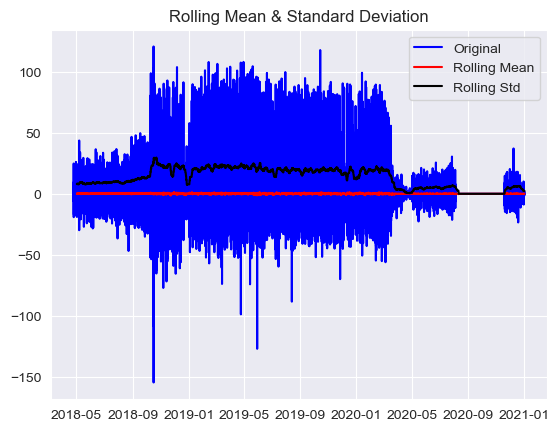

Results of Dickey-Fuller Test:



KeyboardInterrupt: 

In [39]:
df['kWhDelivered_total_diff'] = df['kWhDelivered_total'].diff().dropna() #1. order differentiation
print(len(df))
df.dropna(inplace=True)
print(len(df))
test_stationarity(df['kWhDelivered_total_diff'])

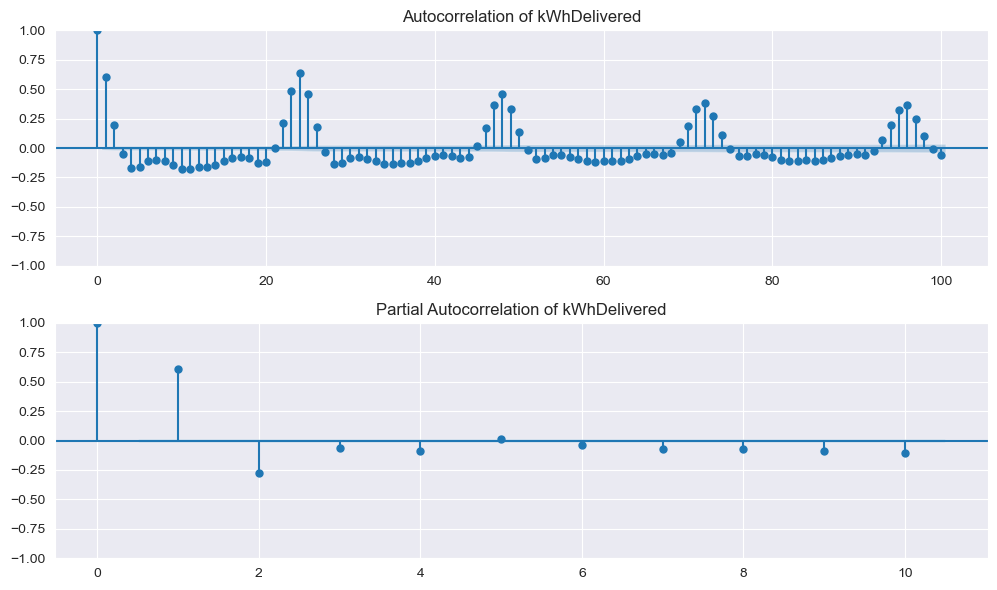

In [40]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(2, 1, figsize=(10, 6)) # 2 rows, 1 column

# ACF-Plot
plot_acf(df['kWhDelivered_total_diff'], lags=100, ax=axes[0])
axes[0].set_title('Autocorrelation of kWhDelivered')

# PACF-Plot
plot_pacf(df['kWhDelivered_total_diff'], lags=10, ax=axes[1])
axes[1].set_title('Partial Autocorrelation of kWhDelivered')

plt.tight_layout()
plt.show()

In [35]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

p, d, q = 2, 1, 5 #Example Values
P, D, Q, m = 1, 1, 1, 24 #Example Values

model = SARIMAX(df['kWhDelivered_total'], order=(p, d, q), seasonal_order=(P, D, Q, m))
model_fit = model.fit()
print(model_fit.summary())

/opt/anaconda3/envs/DynamoData/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/DynamoData/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/envs/DynamoData/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/opt/anaconda3/envs/DynamoData/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Lik

                                      SARIMAX Results                                       
Dep. Variable:                   kWhDelivered_total   No. Observations:                23401
Model:             SARIMAX(2, 1, 5)x(1, 1, [1], 24)   Log Likelihood              -86151.079
Date:                              Sun, 19 Jan 2025   AIC                         172322.158
Time:                                      12:14:31   BIC                         172402.752
Sample:                                           0   HQIC                        172348.328
                                            - 23401                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1966      0.006    -30.926      0.000      -0.209      -0.184
ar.L2          0.76

***

## 3 Neural Network